In [107]:
from io import BytesIO
import boto3
import h5py
import pyhdf
from pyhdf.SD import SD, SDC

# Why?
import os
import tempfile

import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import numpy

%matplotlib inline

In [6]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    done = False
    while not done:
        resp = s3_client.list_objects_v2(**kwargs)
        try:
            for obj in resp['Contents']:
                key = obj['Key']
                if key.startswith(prefix):
                    # print('key: ',key)
                    yield key
        except KeyError:
            print('Empty response from s3 for bucket %s with prefix %s'%(bucket,prefix))
            break

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break
            

In [7]:
def h5_dataset_from_s3(s3_client,bucket,key,filename='file.h5'):
    buff=BytesIO()
    s3_client.download_fileobj(bucket_name,key,buff)
    buff.name = file_name
    buff.seek(0)
    return h5py.File(buff,'r') # returns an hdf5 file object

In [136]:
def hdf4_dataset_from_s3(s3_client,bucket,key,filename='file.hdf'):
    tmpdir = tempfile.TemporaryDirectory()
    fullFilename = os.path.join(tmpdir.name,filename)
    s3_client.download_file(bucket_name,key,fullFilename)
    return SD(fullFilename,SDC.READ),tmpdir,fullFilename # returns an SDS

# Remember to cleanup! tmpdir.cleanup()

def with_hdf4_get(hdf,var,attrs=None):
    sds = hdf.select(var)
    ret = sds.get()
    if attrs is not None:
        d = {}
        for i in attrs:
            d[i] = sds.attributes()[i]
    sds.endaccess()
    if attrs is not None:
        return ret,d
    return ret

In [8]:
s3_client = boto3.client('s3')

865

In [11]:
keys = get_s3_keys('daskhub-data',s3_client,prefix='')
key_list = [key for key in keys]; key_list[0:10]

['GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4',
 'GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191222.nc4',
 'GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4',
 'MODAPS/MOD05/MOD05_L2.A2019336.2300.061.2019337071951.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2300.061.2019337071951_stare.nc',
 'MODAPS/MOD05/MOD05_L2.A2019336.2305.061.2019337071951.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2305.061.2019337071951_stare.nc',
 'MODAPS/MOD05/MOD05_L2.A2019336.2310.061.2019337071934.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952_stare.nc']

## HDF 4 Example

In [85]:
bucket_name='daskhub-data'
key=key_list[3]
print('getting: %s'%(key,))
file_name = str(".".join(key.split('/')[-1].split('.')[0:]))

getting: MODAPS/MOD05/MOD05_L2.A2019336.2300.061.2019337071951.hdf


In [86]:
file4,tmpdir,ff_name = hdf4_dataset_from_s3(s3_client,bucket_name,key,filename=file_name) # tmpdir.cleanup() later...

In [57]:
print(type(file4),type(tmpdir),type(ff_name))
print(ff_name)

<class 'pyhdf.SD.SD'> <class 'tempfile.TemporaryDirectory'> <class 'str'>
/tmp/tmp747lzria/MOD05_L2.A2019336.2300.061.2019337071951.hdf


In [58]:
file4.datasets().keys()

dict_keys(['Latitude', 'Longitude', 'Scan_Start_Time', 'Solar_Zenith', 'Solar_Azimuth', 'Sensor_Zenith', 'Sensor_Azimuth', 'Cloud_Mask_QA', 'Water_Vapor_Near_Infrared', 'Water_Vapor_Correction_Factors', 'Water_Vapor_Infrared', 'Quality_Assurance_Near_Infrared', 'Quality_Assurance_Infrared'])

In [105]:
print(file4.datasets()['Water_Vapor_Infrared'])
img_wvir = with_hdf4_get(file4,'Water_Vapor_Infrared')
print(type(img_wvir))
lat_5km = with_hdf4_get(file4,'Latitude')
lon_5km = with_hdf4_get(file4,'Longitude')

(('Cell_Along_Swath_5km:mod05', 'Cell_Across_Swath_5km:mod05'), (406, 270), 22, 10)
<class 'numpy.ndarray'>


In [137]:
img_wvir,attrs = with_hdf4_get(file4,'Water_Vapor_Infrared',attrs=['add_offset','scale_factor','_FillValue'])
img_wvir[numpy.where(img_wvnir == attrs['_FillValue'])] = 0 # Or use a mask
img_wvir = (img_wvir-attrs['add_offset'])*attrs['scale_factor']

In [77]:
attrs

{'add_offset': 0.0, 'scale_factor': 0.0010000000474974513, '_FillValue': -9999}

In [102]:
numpy.amax(img_wvir)

3679

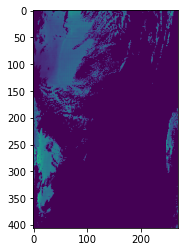

In [138]:
plt.imshow(img_wvnir)
plt.show()

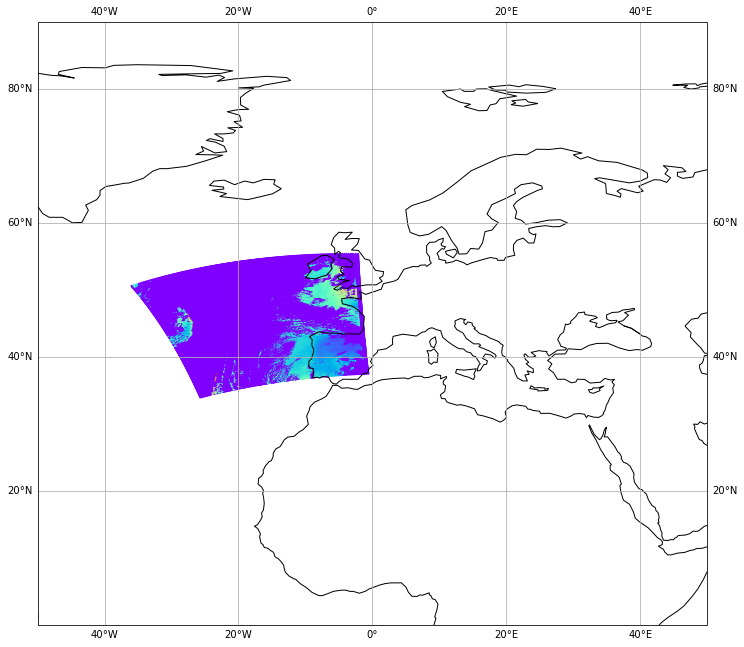

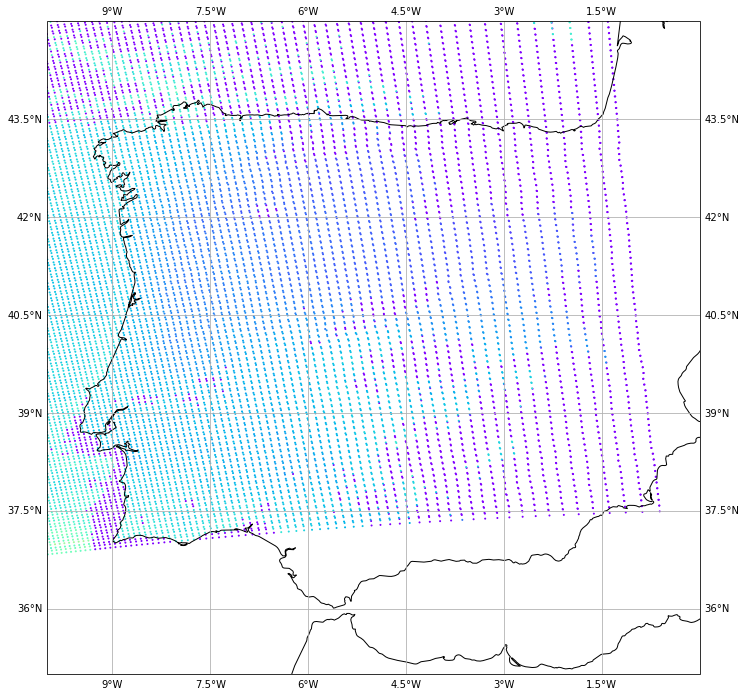

In [139]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(lon_5km,lat_5km,s=1,c=img_wvnir,transform=ccrs.PlateCarree(),cmap='rainbow')
# ax.set_global()
ax.set_extent([-50,50,0,90])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.show()

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(lon_5km,lat_5km,s=1,c=img_wvnir,transform=ccrs.PlateCarree(),cmap='rainbow')
# ax.set_global()
ax.set_extent([-10,0,35,45])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.show()

In [152]:
file4.end(); tmpdir.cleanup()

## HDF 5 Example

In [141]:
bucket_name='daskhub-data'
key=key_list[2]
print('getting: %s'%(key,))
file_name = str(".".join(key.split('/')[-1].split('.')[0:]))

getting: GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4


In [142]:
ds= h5_dataset_from_s3(s3_client,bucket_name,key,filename=file_name)

In [143]:
ds.keys()

<KeysViewHDF5 ['CLDPRS', 'CLDTMP', 'DISPH', 'H1000', 'H250', 'H500', 'H850', 'OMEGA500', 'PBLTOP', 'PS', 'Q250', 'Q500', 'Q850', 'QV10M', 'QV2M', 'SLP', 'T10M', 'T250', 'T2M', 'T2MDEW', 'T2MWET', 'T500', 'T850', 'TO3', 'TOX', 'TQI', 'TQL', 'TQV', 'TROPPB', 'TROPPT', 'TROPPV', 'TROPQ', 'TROPT', 'TS', 'U10M', 'U250', 'U2M', 'U500', 'U50M', 'U850', 'V10M', 'V250', 'V2M', 'V500', 'V50M', 'V850', 'ZLCL', 'lat', 'lon', 'time']>

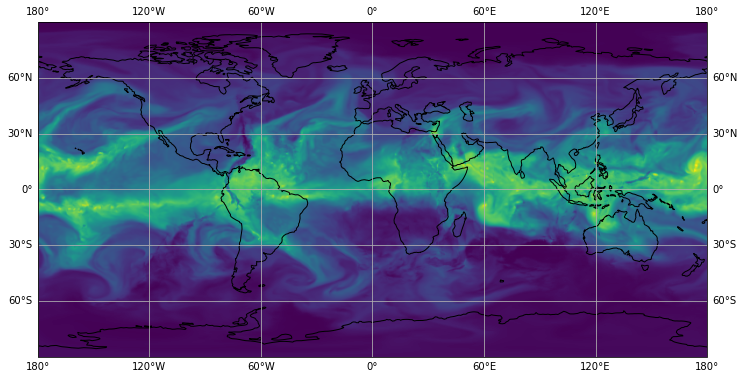

In [170]:
plot_options = {'projection':ccrs.PlateCarree()
                ,'transform':ccrs.Geodetic()
               }
# plot_options['projection']=ccrs.Mollweide()

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return
    
figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=(12,12)),plot_options=plot_options)

proj=figax.plot_options['projection']
# transf=figax.plot_options['transform'] # broken
transf=proj
figax.ax = plt.axes(projection=proj)
figax.ax.set_extent([-180,180,-90,90])
plt.imshow(ds['TQV'][0,:,:],transform=transf,extent=[-180,180,-90,90])
figax.ax.coastlines()
figax.ax.gridlines(draw_labels=True)
plt.show()

In [171]:
ds.close()